# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

** please see comments throughout and final comments in the end of the notebook

In [44]:
# import statements 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [45]:
### important functions that are used in the script
def remove_outliers(df, columns):
    """ Calculates the mean and std of each col passed and replaces outliers with upper or lower limits of """
    for col in columns:

        mean = df[col].mean()
        std = df[col].std()

        upper_limit = mean + 3 * std
        lower_limit = mean - 3 * std

        # Replace outliers with upper or lower limit
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
        df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])

    return df

# define a function to get cross validation score metrics


def get_cross_val_metrics(model, X , y , cv):
    model.fit(X, y)
    cv_scores = cross_val_score(model, X, y , cv = cv)
    # Print the mean and standard deviation of the cross-validation scores
    print("Cross-val scores: {}".format(cv_scores))
    print("Mean cross-val accuracy score: {:.2f} +/- {:.2f}".format(cv_scores.mean(),cv_scores.std()))



def get_class_metrics(model,r1, r2):
    report = classification_report(r1, r2)
    matrix = confusion_matrix(r1,r2)
    print('{} , {} \n {} '.format(matrix, model, report)) 

# and a combination of test set and train set evaluation metrics

def evaluate_model(model , X_train , X_test , y_train ,y_test , cv = 3 , opt_features = None):
    
    """ Used to see how the model generalises to new data and how it fits to the training data"""

    if opt_features is not None:
        X_train_optimal = X_train.loc[:, opt_features]
        X_test_optimal = X_test.loc[:, opt_features]
    else:
        X_train_optimal = X_train
        X_test_optimal = X_test
    
    print('      TRAIN_SET_EVALUATION')
    get_cross_val_metrics(model = model, X = X_train_optimal , y = y_train , cv = cv)
    
    print('       TEST SET EVALUATION')
    get_class_metrics(type(model).__name__ ,r1 = y_test ,r2= model.predict(X_test_optimal))


def select_features(model, X_train, y_train):

    rfecv = RFECV(estimator=model, step=1, cv=3, scoring='accuracy')
    rfecv.fit(X_train, y_train)

    print("Optimal number of features: {}".format(rfecv.n_features_))

    print("Feature rankings: {}".format(rfecv.ranking_))

    optimal_indices = rfecv.get_support(indices=True)
    optimal_features = X_train.columns[optimal_indices].tolist()
    
    print("Optimal features: {}".format(optimal_features))

    return optimal_features

## hyperparameter tuning using GridSearchCV

def tune_hyperparameters(model, param_grid, X_train, y_train, X_test, y_test, opt_features = None):
    if opt_features is not None:
        X_train_optimal = X_train.loc[:, opt_features]
        X_test_optimal = X_test.loc[:, opt_features]
    else:
        X_train_optimal = X_train
        X_test_optimal = X_test

    clf = GridSearchCV(model, param_grid, cv=3)

    clf.fit(X_train_optimal, y_train)

    best_params = clf.best_params_
    print(f'Best parameters: {best_params}')

    y_pred = clf.predict(X_test_optimal)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Test accuracy: {test_accuracy}')

    cv_results = clf.cv_results_
    avg_accuracy = cv_results['mean_test_score'].mean()
    print(f'Average accuracy: {avg_accuracy}')

    return best_params



**Importing, inspecting dealing with missing values, ensuring correct dtypes **

In [46]:
data = pd.read_csv('https://s3.amazonaws.com/talent-assets.datacamp.com/recipe_site_traffic_2212.csv')
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [47]:
# checking for null values
data.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [48]:
data.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

In [49]:
#  for the 'high_traffic' col , high needs to be replaced by 1 and null by 0 in this column


data["high_traffic"] = data["high_traffic"].apply(lambda x: 1 if x == "High" else 0)
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,1
1,2,35.48,38.56,0.66,0.92,Potato,4,1
2,3,914.28,42.68,3.09,2.88,Breakfast,1,0
3,4,97.03,30.56,38.63,0.02,Beverages,4,1
4,5,27.05,1.85,0.80,0.53,Beverages,4,0


In [50]:
data.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic      int64
dtype: object

In [51]:
# lets check the last two object categories to see what they contain
for col in ['category' , 'servings']:
    col_name = col
    unique_vals = data.loc[:, col].unique()
    data_type = data.loc[:, col].dtype
    print(col_name)
    print(f"Unique values: {unique_vals}")
    print(f"Data type: {data_type}")
    print()

category
Unique values: ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
Data type: object

servings
Unique values: ['6' '4' '1' '2' '4 as a snack' '6 as a snack']
Data type: object



In [52]:
# it is clear that the recipe column and index column are the same. so getting rid of one of them
data.set_index('recipe' , inplace=True)
data.reset_index(drop = True , inplace = True)

In [53]:
# convert 'servings' column to numeric
data['servings'] = pd.to_numeric(data['servings'], errors='coerce')

In [54]:
#conversion of 'servings column to numeric has created 3 more null vals'
data.isnull().sum()

calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         3
high_traffic     0
dtype: int64

In [55]:
# this was an attempt to replace the 3 samples containing ' ... as a snack ' vals with ints but doesnt lead to any improvement of the models so not used // they are removed later instead. The ' as a snack ' represents a different quantity of food so it is sensible to remove. We could also try mean imputation but it is only 3 samples and these are unlikely to have any significant effect.
#######
# data['servings'] = data['servings'].astype('str').str[0]).astype('int')


In [56]:
null_rows = data.isnull().any(axis =1)
data[null_rows]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,NaN,NaN,NaN,NaN,Pork,6.0,1
23,NaN,NaN,NaN,NaN,Meat,2.0,0
48,NaN,NaN,NaN,NaN,Chicken Breast,4.0,0
82,NaN,NaN,NaN,NaN,Meat,4.0,1
89,NaN,NaN,NaN,NaN,Pork,6.0,1
116,NaN,NaN,NaN,NaN,Chicken Breast,6.0,1
121,NaN,NaN,NaN,NaN,Dessert,2.0,1
136,NaN,NaN,NaN,NaN,One Dish Meal,2.0,1
149,NaN,NaN,NaN,NaN,Potato,2.0,1
187,NaN,NaN,NaN,NaN,Pork,4.0,1


In [57]:
# from above we can see that the 'calories' , 'carboxydrate' , 'sugar' , 'protein' data are missing simultaneously for all 52 samples. There must have been an issue in data collection of nutritional data for these recipies. It is reasonable to drop these as well since 4/6 features are absent.
data= data.dropna()
data.shape

(892, 7)

** Exploratory Data analysis**

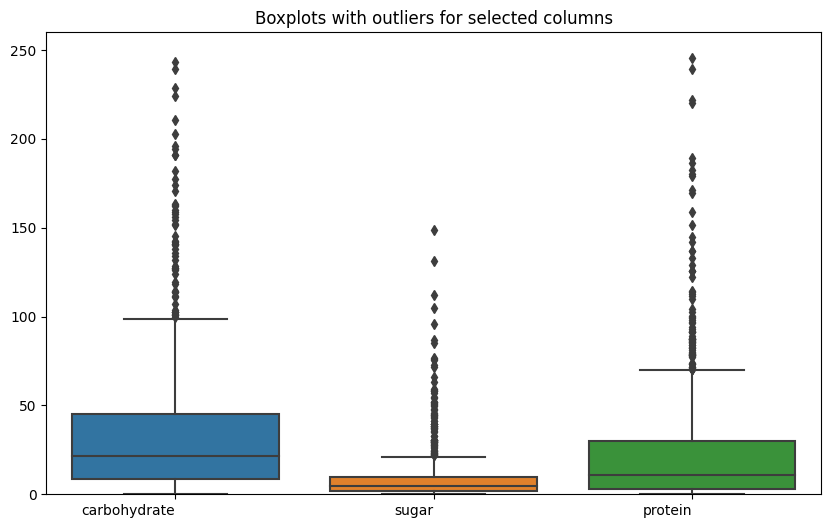

In [58]:
# boxplots for outliers in numerical data 
cols = ['carbohydrate', 'sugar', 'protein']


fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=data[cols], ax=ax, showfliers=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')


ax.set_ylim([0, 260])
ax.set_title('Boxplots with outliers for selected columns')

plt.show()


In [59]:
# We can see that the nutritional data contains outliers. the same is true for the 'calories' col which is omitted from above as it is in different scale - but shows a similar picture. Inspection of summary statistics also shows extreme outlier presence

data.describe()

,calories,carbohydrate,sugar,protein,servings,high_traffic
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,433.484989,35.062971,9.043206,24.142018,3.454036,0.597534
std,450.997596,44.005332,14.699529,36.429244,1.736618,0.490670
min,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,110.145000,8.320000,1.687500,3.177500,2.000000,0.000000
50%,287.010000,21.480000,4.545000,10.775000,4.000000,1.000000
75%,595.930000,44.907500,9.800000,30.015000,4.000000,1.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


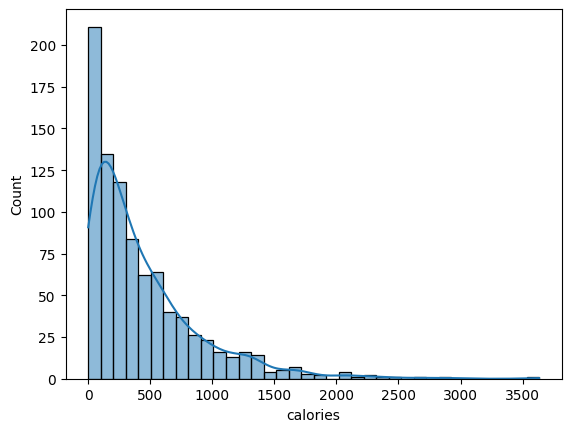

In [60]:
# some general EDA plots
# histogram of the count of recipies against calories
sns.histplot(data=data, x='calories', kde=True)
plt.show()
# data is highly skewed towards the y axis

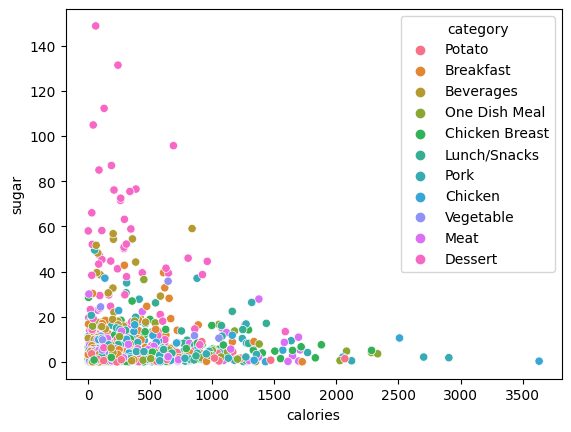

In [61]:
# Create scatter plot of calories vs. protein
sns.scatterplot(data=data, x='calories', y='sugar', hue='category')
plt.show()
# shows visually that the highest foods in sugar are desserts

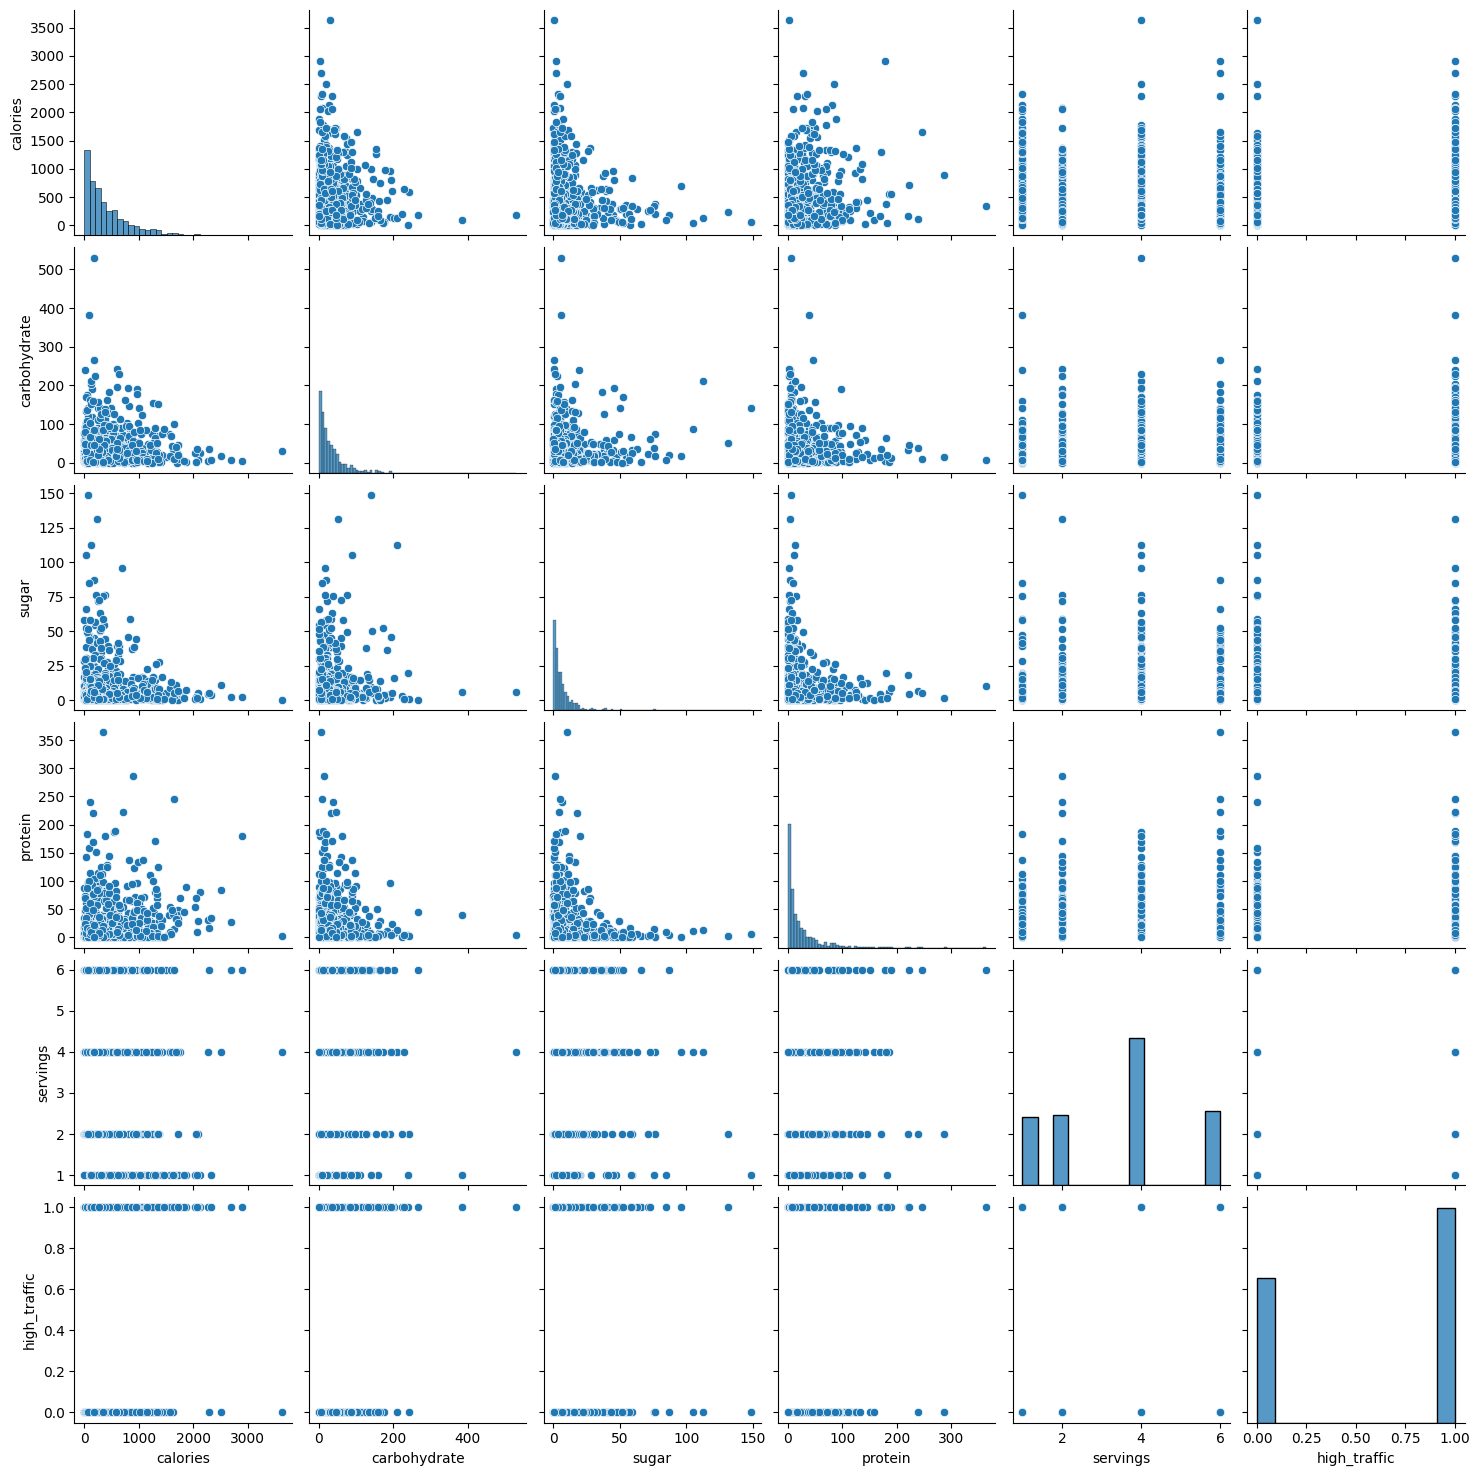

In [62]:
# Create pair plot of all numeric variables
sns.pairplot(data=data.drop([ 'category'], axis=1).dropna())
plt.show()
# shows the structure of the correlations of the data
# the data is highly skewed. 

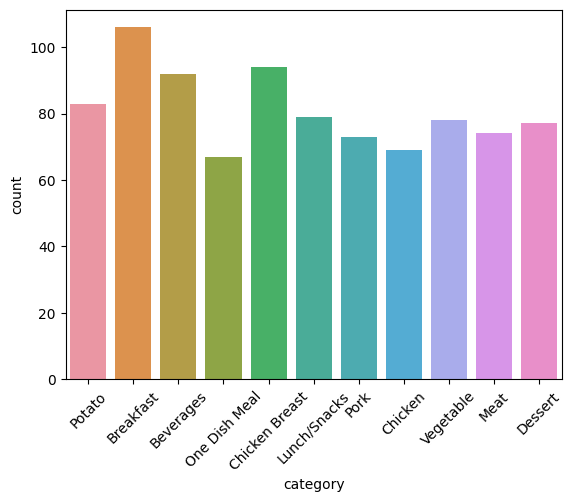

In [63]:
# lets get a distribution of our remaining categorical col 'category'
# Create bar chart of category column
sns.countplot(data=data, x='category')
plt.xticks(rotation=45)
plt.show()
# these will be one hot encoded. we have a reasonably even distribution of all categories which is good

<AxesSubplot: >

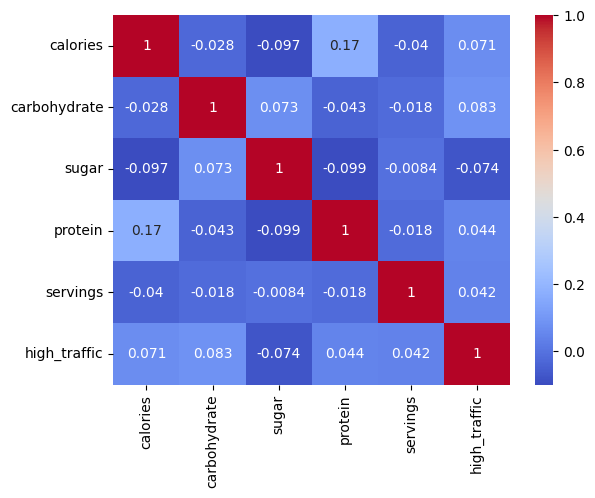

In [64]:
# Create a correlation matrix
corr_matrix = data.corr(method='pearson')

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# no collinearity between features present but also low correlation of the numerical features and the target var

**One Hot Encoding of the 'category' col**

In [65]:
# one hot encode the category variable and concat with numerical to make  the final dataframe
one_hot_encoded = pd.get_dummies(data['category'] , drop_first=True)
data = pd.concat([data , one_hot_encoded] , axis =1)
data.drop('category' , axis =1 , inplace = True)
data.head()

,calories,carbohydrate,sugar,protein,servings,high_traffic,Breakfast,Chicken,Chicken Breast,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
1,35.48,38.56,0.66,0.92,4.0,1,0,0,0,0,0,0,0,0,1,0
2,914.28,42.68,3.09,2.88,1.0,0,1,0,0,0,0,0,0,0,0,0
3,97.03,30.56,38.63,0.02,4.0,1,0,0,0,0,0,0,0,0,0,0
4,27.05,1.85,0.80,0.53,4.0,0,0,0,0,0,0,0,0,0,0,0
5,691.15,3.46,1.65,53.93,2.0,1,0,0,0,0,0,0,1,0,0,0


**Removing outliers and scaling data**

In [66]:
# splitting to features and target variable
X = data.drop(columns = 'high_traffic' , axis =1)

y = np.ravel(data[['high_traffic']])

In [67]:
# I have written a function at the top of the script which replaces outliers in all numerical data cols, specifically the highest vals than the limit of +3 standard deviations are replaced with that upper limit

data = remove_outliers(X, ['calories', 'carbohydrate', 'sugar', 'protein'])

In [68]:
data.describe()
# here we can see how the max changes for all cols above

,calories,carbohydrate,sugar,protein,servings,Breakfast,Chicken,Chicken Breast,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,424.852644,33.759308,8.426679,22.828672,3.454036,0.118834,0.077354,0.105381,0.086323,0.088565,0.082960,0.075112,0.081839,0.093049,0.087444
std,414.510799,36.764089,11.389859,29.826606,1.736618,0.323775,0.267303,0.307216,0.280998,0.284274,0.275976,0.263720,0.274272,0.290665,0.282643
min,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.145000,8.320000,1.687500,3.177500,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,287.010000,21.480000,4.545000,10.775000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,595.930000,44.907500,9.800000,30.015000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1786.477776,167.078967,53.141794,133.429750,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


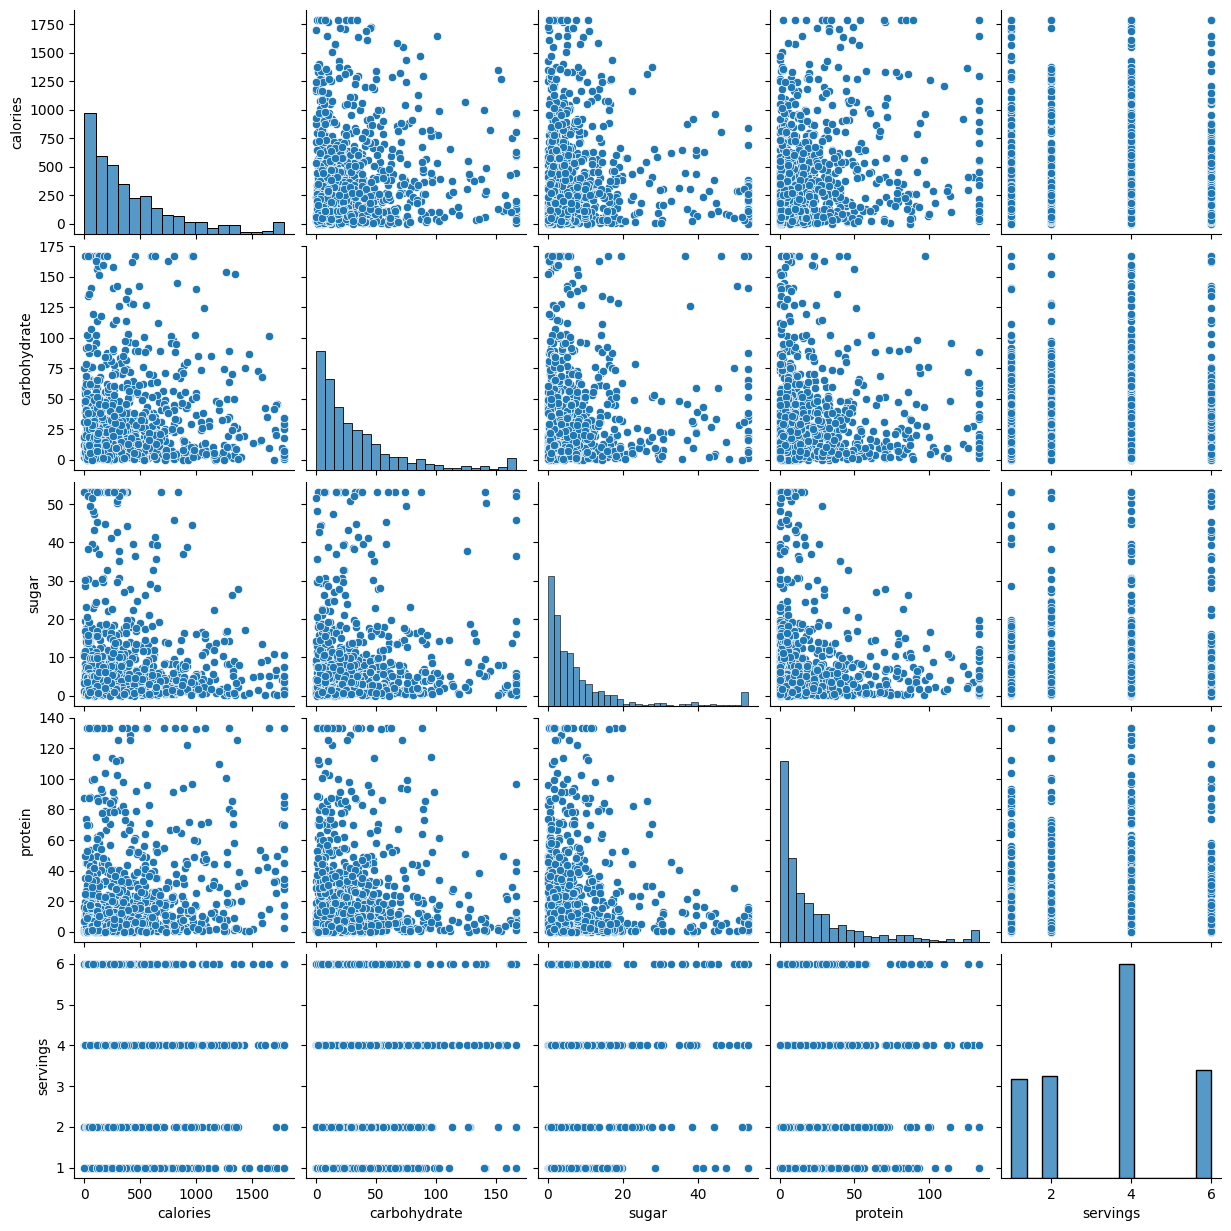

In [69]:
# Create pair plot of all numeric variables
sns.pairplot(data=X.iloc[:,:5])
plt.show()


In [70]:
# It was not mentioned so far in this notebook but there is a slight imbalance in the data favoring one class
from collections import Counter
count_dict = dict(Counter(y))
count_dict


{1: 533, 0: 359}

In [71]:
# splitting to test and training sets / # stratify = y ensures the same proportion of positive samples in train and test
X_train, X_test , y_train , y_test = train_test_split(X, y , test_size=0.3, stratify=y, random_state = 42)


In [72]:

# # from the desciption of the dataset above, some variables should be scaled as models that operate in linear space will likely be tested
columns_to_scale = ['calories' ,'carbohydrate', 'sugar', 'protein']
scaler = PowerTransformer()
# i used this scaler to get the numeric columns above approximately normally distributed
#fit scaler to training first and transform
X_train_scaled = X_train.copy()
X_train_scaled.loc[: ,columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
# # use the scaler object for the test
X_test_scaled = X_test.copy()
X_test_scaled.loc[: , columns_to_scale]  = scaler.transform(X_test[columns_to_scale] )



In [73]:
X_train_scaled.head()

,calories,carbohydrate,sugar,protein,servings,Breakfast,Chicken,Chicken Breast,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
602,-1.227793,0.372008,-0.004659,1.099136,2.0,0,0,1,0,0,0,0,0,0,0
466,-1.272611,-1.193765,0.930157,-1.382720,6.0,0,0,0,0,0,0,0,0,0,0
814,0.044820,0.648736,-1.804544,0.599949,4.0,0,0,1,0,0,0,0,0,0,0
853,0.309593,-0.689870,-1.915962,-1.508999,6.0,0,0,0,1,0,0,0,0,0,0
108,0.722721,0.575152,0.793795,-0.487603,6.0,0,0,0,1,0,0,0,0,0,0


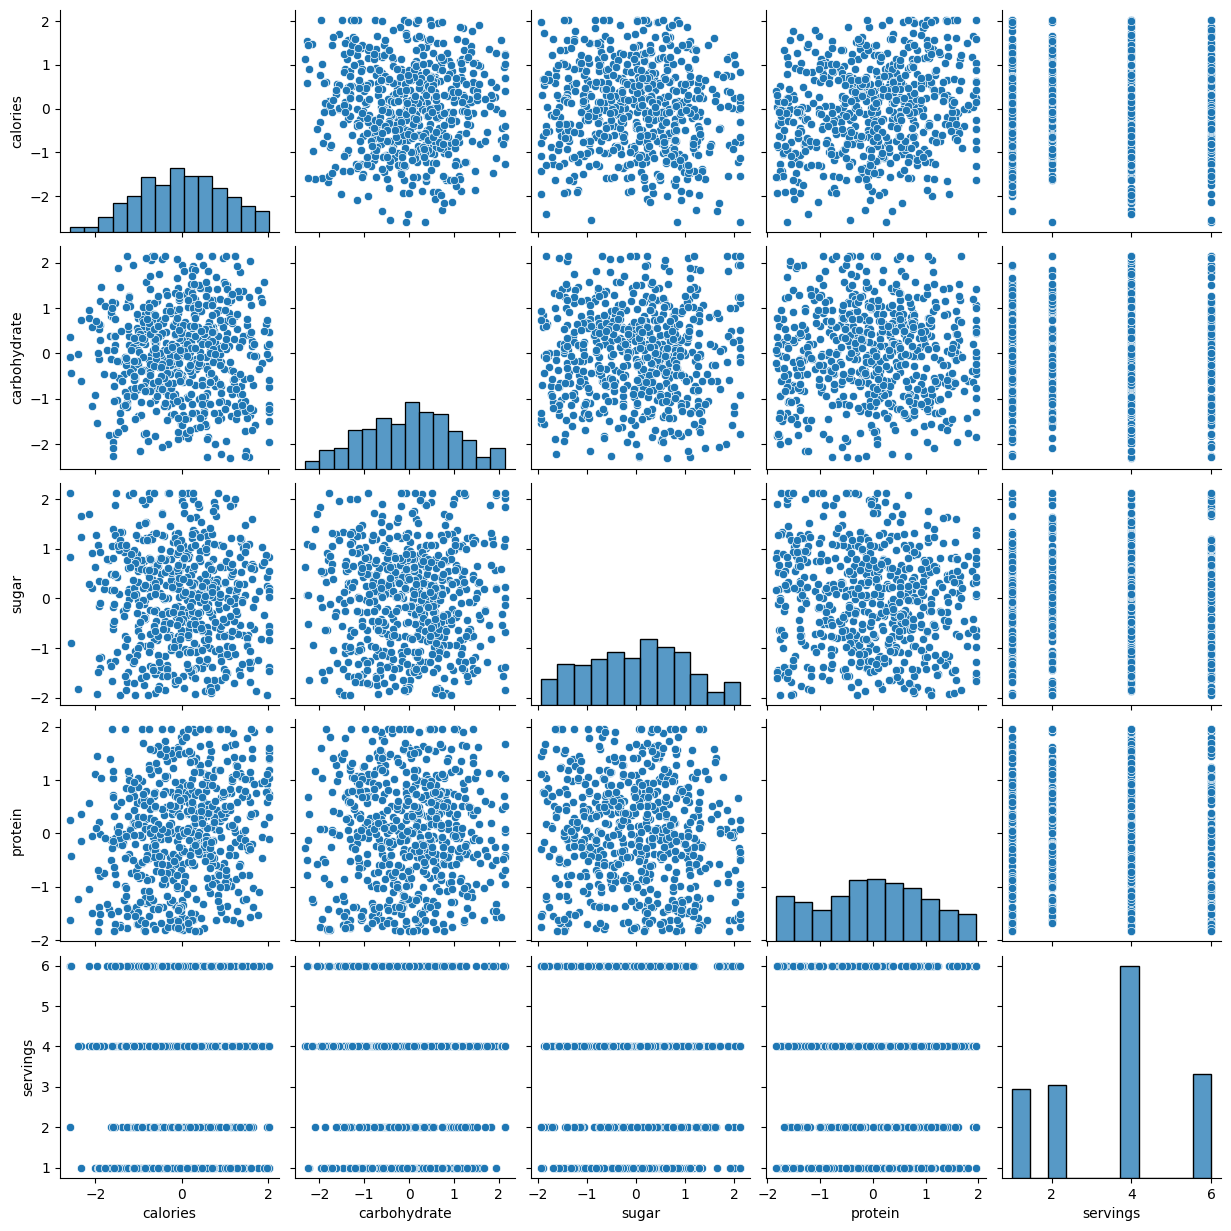

In [74]:
# Create pair plot of all numeric variables
sns.pairplot(data=X_train_scaled.iloc[:,:5])
plt.show()

In [75]:
X_train_scaled.describe()

,calories,carbohydrate,sugar,protein,servings,Breakfast,Chicken,Chicken Breast,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
count,6.240000e+02,6.240000e+02,6.240000e+02,6.240000e+02,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,1.423363e-16,-1.138690e-16,1.224092e-16,1.138690e-16,3.506410,0.112179,0.078526,0.123397,0.067308,0.083333,0.083333,0.086538,0.092949,0.086538,0.092949
std,1.000802e+00,1.000802e+00,1.000802e+00,1.000802e+00,1.718549,0.315840,0.269213,0.329157,0.250755,0.276607,0.276607,0.281383,0.290593,0.281383,0.290593
min,-2.589593e+00,-2.318908e+00,-1.942186e+00,-1.834971e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.362069e-01,-7.299262e-01,-7.637187e-01,-7.640801e-01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.181219e-03,3.574511e-02,5.782709e-02,2.267399e-02,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.160560e-01,7.170710e-01,7.340332e-01,7.408702e-01,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.022419e+00,2.137504e+00,2.123706e+00,1.950621e+00,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
# I have included some good models to test as classifiers for our problem
# Fit the models and make predictions on the test set
models = [
    LogisticRegression(random_state =42),
    DecisionTreeClassifier(random_state =42),
    RandomForestClassifier(random_state =42),
    SVC(random_state =42),
    KNeighborsClassifier(),
    GaussianNB()
    ,GradientBoostingClassifier(random_state=42)
]
results = []
for model in models:
    model_name = type(model).__name__
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'Model': model_name, 'Accuracy': accuracy})

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

results_df =results_df.sort_values(by='Accuracy', ascending= False)
print(results_df)

                        Model  Accuracy
2      RandomForestClassifier  0.779851
0          LogisticRegression  0.772388
3                         SVC  0.757463
6  GradientBoostingClassifier  0.738806
5                  GaussianNB  0.690299
1      DecisionTreeClassifier  0.652985
4        KNeighborsClassifier  0.641791


importantly, the above cell was run with and without replacing outliers and the performance of all models was improved.

I plan to explore Logistic Regression , SVC and RandomForestClassifier further in a consistent way. For non-repeated code I use functions from the beginning of the script. 

**Logistic Regression**

In [77]:
log_reg_optimal_features= select_features(model = LogisticRegression(random_state=42) , X_train = X_train_scaled ,y_train =  y_train)


Optimal number of features: 10
Feature rankings: [3 5 6 1 4 1 2 1 1 1 1 1 1 1 1]
Optimal features: ['protein', 'Breakfast', 'Chicken Breast', 'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']


In [78]:
best_params_lg= tune_hyperparameters(model=LogisticRegression(random_state=42) , param_grid={
    'penalty': ['l1', 'l2'],
    'C': [1, 2, 3 ,4, 5,6,7,8],
    'solver': ['liblinear']
} , X_train = X_train_scaled , y_train = y_train , X_test = X_test_scaled , y_test = y_test , opt_features=log_reg_optimal_features)


Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Test accuracy: 0.7686567164179104
Average accuracy: 0.7424879807692307


In [79]:
evaluate_model(LogisticRegression(**best_params_lg, random_state = 42),X_train_scaled, X_test_scaled ,y_train , y_test ,cv =3, opt_features =log_reg_optimal_features )

      TRAIN_SET_EVALUATION
Cross-val scores: [0.75961538 0.72596154 0.75480769]
Mean cross-val accuracy score: 0.75 +/- 0.01
       TEST SET EVALUATION
[[ 76  32]
 [ 30 130]] , LogisticRegression 
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       108
           1       0.80      0.81      0.81       160

    accuracy                           0.77       268
   macro avg       0.76      0.76      0.76       268
weighted avg       0.77      0.77      0.77       268
 


**SVC**

In [80]:
SVC_optimal_features= select_features(model = LinearSVC(max_iter = 2000) , X_train = X_train_scaled ,y_train =  y_train)


Optimal number of features: 7
Feature rankings: [7 6 9 5 8 4 3 2 1 1 1 1 1 1 1]
Optimal features: ['Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']


In [81]:

best_params_SVC= tune_hyperparameters(model = LinearSVC(max_iter = 10000 ) , param_grid = {'C': [0.01,  0.1, 1, 10, 100],
              'penalty': [ 'l2'],
} , X_train = X_train_scaled , y_train = y_train , X_test = X_test_scaled , y_test = y_test , opt_features=SVC_optimal_features)

Best parameters: {'C': 0.1, 'penalty': 'l2'}
Test accuracy: 0.7947761194029851
Average accuracy: 0.7182692307692307


In [82]:
evaluate_model(LinearSVC(**best_params_SVC),X_train_scaled, X_test_scaled ,y_train , y_test ,cv =3, opt_features =SVC_optimal_features )

      TRAIN_SET_EVALUATION
Cross-val scores: [0.78365385 0.70673077 0.75480769]
Mean cross-val accuracy score: 0.75 +/- 0.03
       TEST SET EVALUATION
[[ 80  28]
 [ 27 133]] , LinearSVC 
               precision    recall  f1-score   support

           0       0.75      0.74      0.74       108
           1       0.83      0.83      0.83       160

    accuracy                           0.79       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.79      0.79      0.79       268
 


** Random Forrest Classifier**

In [83]:
RF_opt_features = select_features(model = RandomForestClassifier() ,X_train = X_train_scaled ,y_train =  y_train) 

Optimal number of features: 13
Feature rankings: [1 1 1 1 1 1 1 1 3 2 1 1 1 1 1]
Optimal features: ['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'Breakfast', 'Chicken', 'Chicken Breast', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']


In [84]:

best_params_RF= tune_hyperparameters(model=RandomForestClassifier() , param_grid = {
    'n_estimators': [100, 150 ,200],
    'max_depth': [5, 10 , None],
    'min_samples_split': [2,4 , 5],
    'min_samples_leaf': [1, 2, 4, 5],
    
} , X_train = X_train_scaled , y_train = y_train , X_test = X_test_scaled , y_test = y_test , opt_features = RF_opt_features)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 150}
Test accuracy: 0.7686567164179104
Average accuracy: 0.7141352089268754


In [85]:
evaluate_model(RandomForestClassifier(**best_params_RF),X_train_scaled, X_test_scaled ,y_train , y_test ,cv =3, opt_features =RF_opt_features )

      TRAIN_SET_EVALUATION
Cross-val scores: [0.76923077 0.69711538 0.6875    ]
Mean cross-val accuracy score: 0.72 +/- 0.04
       TEST SET EVALUATION
[[ 71  37]
 [ 27 133]] , RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.72      0.66      0.69       108
           1       0.78      0.83      0.81       160

    accuracy                           0.76       268
   macro avg       0.75      0.74      0.75       268
weighted avg       0.76      0.76      0.76       268
 


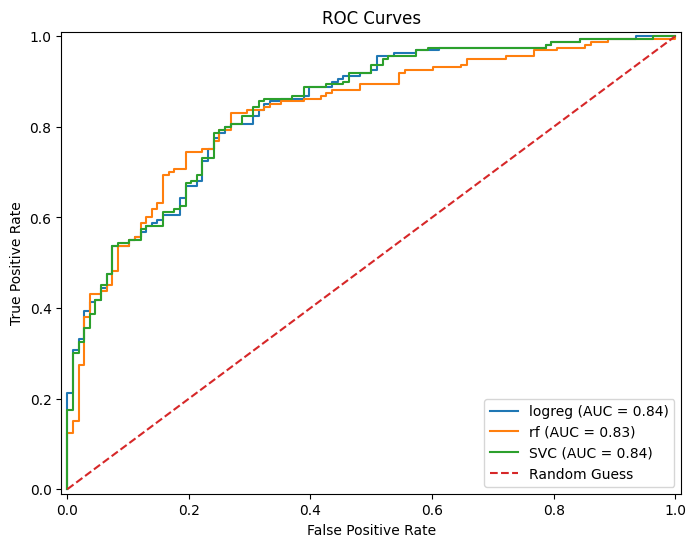

In [86]:
def train_model(model, X_train, y_train, X_test, y_test, opt_features=None):
    if opt_features is not None:
        X_train_optimal = X_train.loc[:, opt_features]
        X_test_optimal = X_test.loc[:, opt_features]
    else:
        X_train_optimal = X_train
        X_test_optimal = X_test
        
    if isinstance(model, LinearSVC):
        model.fit(X_train_optimal , y_train)
        y_pred = model.decision_function(X_test_optimal)
        y_pred = 1 / (1 + np.exp(-y_pred))  # apply sigmoid function
    else:
        model.fit(X_train_optimal , y_train)
        y_pred = model.predict_proba(X_test_optimal)[:, 1]
        

        
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc
plt.figure(figsize=(8, 6))
models =[('logreg', LogisticRegression(**best_params_lg, max_iter=10000)),   ('rf' , RandomForestClassifier(**best_params_RF)) , ('SVC' , LinearSVC(**best_params_SVC))  ]

for model_name, model in models:
    fpr, tpr, roc_auc = train_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (model_name, roc_auc))

# Plot the random guess curve
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()


In the classification problem for predicting which recipes will attract high attention on a website, several models were screened to check their performance on rescaled datasets with extreme outliers removed. Three models RandomForrestClassifier , Logistic Regression and SVC were further explored.
final comments for Logistic Regression and SVC models both shown to have an AUC of 0.84. What this means is that both models have a high probability of ranking a randomly selected positive instances higher than a randomly selected negative instance. In other words, the model can correctly distinguish between positive and negative instances with a high degree of accuracy. Furthermore the mean cross-validation accuracy scores for both models are 0.75 and their standard deviation of the scores are [0.01 , 0.03], indicating that both models perform  consistently across the different splits of the training data. Performance in the test data is also good as seen by the test set evaluation function.


In [ ]:

# For SVC                precision    recall  f1-score   support

#            0       0.75      0.74      0.74       108
#            1       0.83      0.83      0.83       160

#     accuracy                           0.79       268
 

In [ ]:
# for LogisticRegression 
#                precision    recall  f1-score   support

#            0       0.72      0.70      0.71       108
#            1       0.80      0.81      0.81       160

#     accuracy                           0.77       268

 The SVC slightly outperforms the LogisticRegression in the test data but the opposite is true for the training data, specifically for the standard deviation within the splits. Overall, as seen above, both models have a good balances of precision and recall metrics across both classes, reflected across the harmonic f1 scores. Slight imbalance in the 0 and 1 classes explained due to the slight class imbalance shown by the Counter dict {1: 533, 0: 359}. Perhaps it would be useful to address this in future work by implementing class_weights ,  but I could not get it to work within the time limit of the exercise.  

Buisness metrics - 
Since, the business goal is to increase recipe pageviews, we can evaluate the model's performance by measuring the increase in pageviews for the recipes predicted as popular by the model. We can also compare the model's predictions to the actual recipe pageviews and calculate the correlation coefficient or root mean squared error to measure the model's accuracy.

in general, if the buisness is performing well and predicting recipes with a good level of accuracy then the model is perhaps achieving adequately well, otherwise further tuning is required.

Recommendations: Of course training the models in larger datasets can be beneficial and larger datasets may allow for other models to get trained appropriately - neural nets.
In terms of the features provided, I would suggest that there is some info that may be useful in predicting recipe popularity that is absent. e.g. The time to complete a recipe is likely a really important factor determining whether someone would decide to cook it ; however this type of data is absent.

This concludes my analysis. In general there are a few things that I would attempt next if I had more time. In terms of the actual analysis and model fitting it is clear that there are several models, namely Logistic regression with L2 regularization and SVC employing a linear kernel and also a L2 regularization. In both cases, the L2 regularization penalty applied to the coefficients, helped to prevent overfitting and improve generalization performance as described in the metrics above. what is also really interesting is that the recursive feature elimination performed for both Logistic Regression and SVC show that SVC =['Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']
and logreg = ['protein', 'Breakfast', 'Chicken Breast', 'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable'] , are in resonably good agreement, and also show that the 'category' column of the original dataset is particularly important in the classification task. 
Since there are some classifiers that perform reasonably well in this classification task, one may attempt stacking and voting ensembles in future work to see if any more information can be extracted from the data. From the accuracy scores shown above for SVC and LogReg, I suggest that the 80% accuracy the company is looking for is certainly possible, but requires further optimization.


## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation